<a href="https://colab.research.google.com/github/bhxvxshh/Plant-Disease-diagnosis/blob/main/plant_disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, manually select: Runtime > Change runtime type > Hardware accelerator > GPU
# Then run this cell to verify GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Clone the repository (downloads all data)
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

# Install dependencies
!pip install -q matplotlib seaborn scikit-learn

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2670 (delta 23), reused 40 (delta 22), pack-reused 2628 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 35.56 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd


In [ ]:
%%shell

# Check directory structure
find PlantDoc-Dataset -type d -not -path "*/\.*" | sort

# Use the fixed command to count images properly
# Fixed command to count images in each class

echo "Training set counts:"
find PlantDoc-Dataset/train -type d -name "*" -not -path "*/\.*" | while read dir; do
    if [ "$dir" != "PlantDoc-Dataset/train" ]; then
        count=$(find "$dir" -type f -name "*.jpg" | wc -l)
        echo "$dir: $count"
    fi
done

echo "Test set counts:"
find PlantDoc-Dataset/test -type d -name "*" -not -path "*/\.*" | while read dir; do
    if [ "$dir" != "PlantDoc-Dataset/test" ]; then
        count=$(find "$dir" -type f -name "*.jpg" | wc -l)
        echo "$dir: $count"
    fi
done


PlantDoc-Dataset
PlantDoc-Dataset/test
PlantDoc-Dataset/test/Apple leaf
PlantDoc-Dataset/test/Apple rust leaf
PlantDoc-Dataset/test/Apple Scab Leaf
PlantDoc-Dataset/test/Bell_pepper leaf
PlantDoc-Dataset/test/Bell_pepper leaf spot
PlantDoc-Dataset/test/Blueberry leaf
PlantDoc-Dataset/test/Cherry leaf
PlantDoc-Dataset/test/Corn Gray leaf spot
PlantDoc-Dataset/test/Corn leaf blight
PlantDoc-Dataset/test/Corn rust leaf
PlantDoc-Dataset/test/grape leaf
PlantDoc-Dataset/test/grape leaf black rot
PlantDoc-Dataset/test/Peach leaf
PlantDoc-Dataset/test/Potato leaf early blight
PlantDoc-Dataset/test/Potato leaf late blight
PlantDoc-Dataset/test/Raspberry leaf
PlantDoc-Dataset/test/Soyabean leaf
PlantDoc-Dataset/test/Squash Powdery mildew leaf
PlantDoc-Dataset/test/Strawberry leaf
PlantDoc-Dataset/test/Tomato Early blight leaf
PlantDoc-Dataset/test/Tomato leaf
PlantDoc-Dataset/test/Tomato leaf bacterial spot
PlantDoc-Dataset/test/Tomato leaf late blight
PlantDoc-Dataset/test/Tomato leaf mosaic v

In [ ]:
# Set parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "PlantDoc-Dataset"
MODEL_SAVE_PATH = "plant_disease_model.h5"

In [ ]:
# Fix for the "test_datagen is not defined" error

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "PlantDoc-Dataset"
MODEL_SAVE_PATH = "plant_disease_model.h5"

# Import required libraries (if not already imported)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # 20% of data for validation/test
)

# Create data generator for validation/test without augmentation
# This was missing in the previous code
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Now this will work because test_datagen is defined
validation_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Print class information
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 1885 images belonging to 28 classes.
Found 457 images belonging to 28 classes.
Number of classes: 28
Class names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']
Training samples: 1885
Validation samples: 457


In [ ]:
# Step 8: Create the model
print("Creating model...")

# Use MobileNetV2 (we could use a heavier model with GPU)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

Creating model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,425,564 (9.25 MB)

 Trainable params: 167,580 (654.61 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Step 9: Train the model
print("Training model...")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.1596 - loss: 3.1221
Epoch 1: val_accuracy improved from -inf to 0.28884, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1606 - loss: 3.1171 - val_accuracy: 0.2888 - val_loss: 2.4171
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.3505 - loss: 2.2105
Epoch 2: val_accuracy improved from 0.28884 to 0.35011, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 928ms/step - accuracy: 0.3508 - loss: 2.2093 - val_accuracy: 0.3501 - val_loss: 2.1413
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.4283 - loss: 1.9162
Epoch 3: val_accuracy improved from 0.35011 to 0.40263, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 908ms/step - accuracy: 0.4285 - loss: 1.9153 - val_accuracy: 0.4026 - val_loss: 1.9861
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5037 - loss: 1.6530
Epoch 4: val_accuracy improved from 0.40263 to 0.40919, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 942ms/step - accuracy: 0.5037 - loss: 1.6532 - val_accuracy: 0.4092 - val_loss: 1.9150
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.5271 - loss: 1.5378
Epoch 5: val_accuracy did not improve from 0.40919
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 943ms/step - accuracy: 0.5273 - loss: 1.5378 - val_accuracy: 0.4026 - val_loss: 1.8931
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.5366 - loss: 1.4924
Epoch 6: val_accuracy improved from 0.40919 to 0.43982, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 56s 949ms/step - accuracy: 0.5369 - loss: 1.4913 - val_accuracy: 0.4398 - val_loss: 1.8097
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.5987 - loss: 1.3108
Epoch 7: val_accuracy did not improve from 0.43982
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 923ms/step - accuracy: 0.5984 - loss: 1.3117 - val_accuracy: 0.4311 - val_loss: 1.8353
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6227 - loss: 1.2628
Epoch 8: val_accuracy did not improve from 0.43982
59/59 ━━━━━━━━━━━━━━━━━━━━ 56s 946ms/step - accuracy: 0.6224 - loss: 1.2634 - val_accuracy: 0.4158 - val_loss: 1.7910
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6121 - loss: 1.2373
Epoch 9: val_accuracy improved from 0.43982 to 0.44420, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 936ms/step - accuracy: 0.6122 - loss: 1.2370 - val_accuracy: 0.4442 - val_loss: 1.7718
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.6328 - loss: 1.1960
Epoch 10: val_accuracy did not improve from 0.44420
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 933ms/step - accuracy: 0.6328 - loss: 1.1957 - val_accuracy: 0.4201 - val_loss: 1.7897
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6596 - loss: 1.1215
Epoch 11: val_accuracy improved from 0.44420 to 0.44858, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 923ms/step - accuracy: 0.6593 - loss: 1.1219 - val_accuracy: 0.4486 - val_loss: 1.7850
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.6561 - loss: 1.0768
Epoch 12: val_accuracy did not improve from 0.44858
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 937ms/step - accuracy: 0.6561 - loss: 1.0774 - val_accuracy: 0.4376 - val_loss: 1.8056
Epoch 13/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6796 - loss: 1.0074
Epoch 13: val_accuracy improved from 0.44858 to 0.46608, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6796 - loss: 1.0076 - val_accuracy: 0.4661 - val_loss: 1.7849
Epoch 14/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.6813 - loss: 1.0331
Epoch 14: val_accuracy did not improve from 0.46608
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 917ms/step - accuracy: 0.6812 - loss: 1.0329 - val_accuracy: 0.4617 - val_loss: 1.7731
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


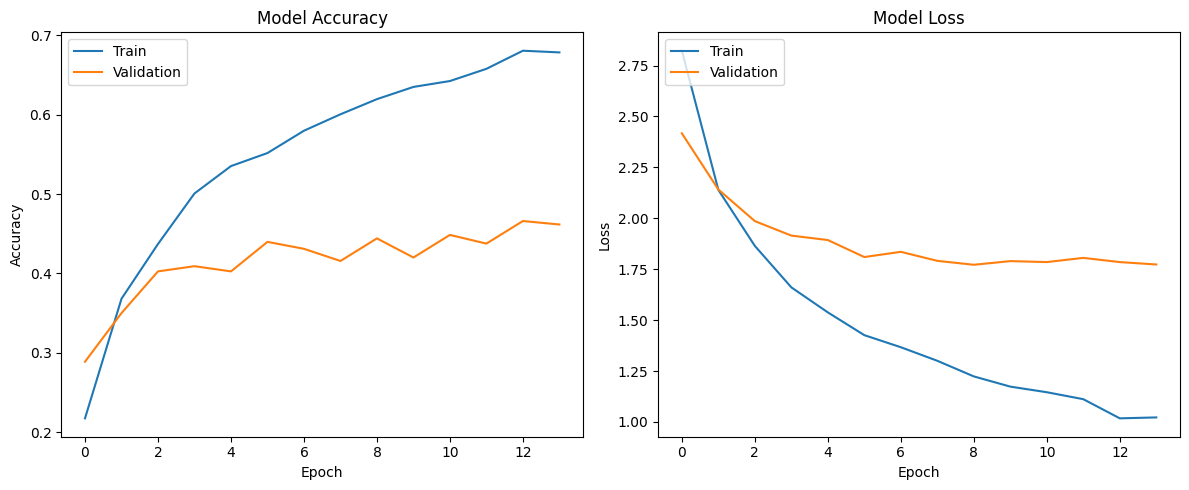

In [ ]:
# Step 10: Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig("training_history.png")
plt.show()


In [ ]:
# Step 11: Fine-tune the model (optional but recommended with GPU)
print("Fine-tuning model...")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze all the layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Fine-tuning model...
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5090 - loss: 1.6506
Epoch 1: val_accuracy did not improve from 0.46608
59/59 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5095 - loss: 1.6481 - val_accuracy: 0.4376 - val_loss: 1.9393
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.6458 - loss: 1.1653
Epoch 2: val_accuracy did not improve from 0.46608
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 899ms/step - accuracy: 0.6456 - loss: 1.1658 - val_accuracy: 0.4508 - val_loss: 2.0353
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.6777 - loss: 1.0292
Epoch 3: val_accuracy did not improve from 0.46608
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 898ms/step - accuracy: 0.6776 - loss: 1.0295 - val_accuracy: 0.4398 - val_loss: 2.0201
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.7197 - loss: 0.9263
Epoch 4: val_accuracy did not improve from 0.46608
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 896ms/step - accuracy: 0.7197 - loss: 0.9264 - va

Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 607ms/step - accuracy: 0.4308 - loss: 2.0673
Test accuracy: 0.4376
Test loss: 1.9393
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step
Classification Report:
                                      precision    recall  f1-score   support

                     Apple Scab Leaf       0.44      0.44      0.44        16
                          Apple leaf       0.71      0.31      0.43        16
                     Apple rust leaf       0.60      0.20      0.30        15
                    Bell_pepper leaf       0.27      0.30      0.29        10
               Bell_pepper leaf spot       0.29      0.17      0.21        12
                      Blueberry leaf       0.22      0.52      0.31        21
                         Cherry leaf       0.20      0.33      0.25         9
                 Corn Gray leaf spot       0.44      0.33      0.38        12
                    Corn leaf blight       0.71      0.81      0.75        36
                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

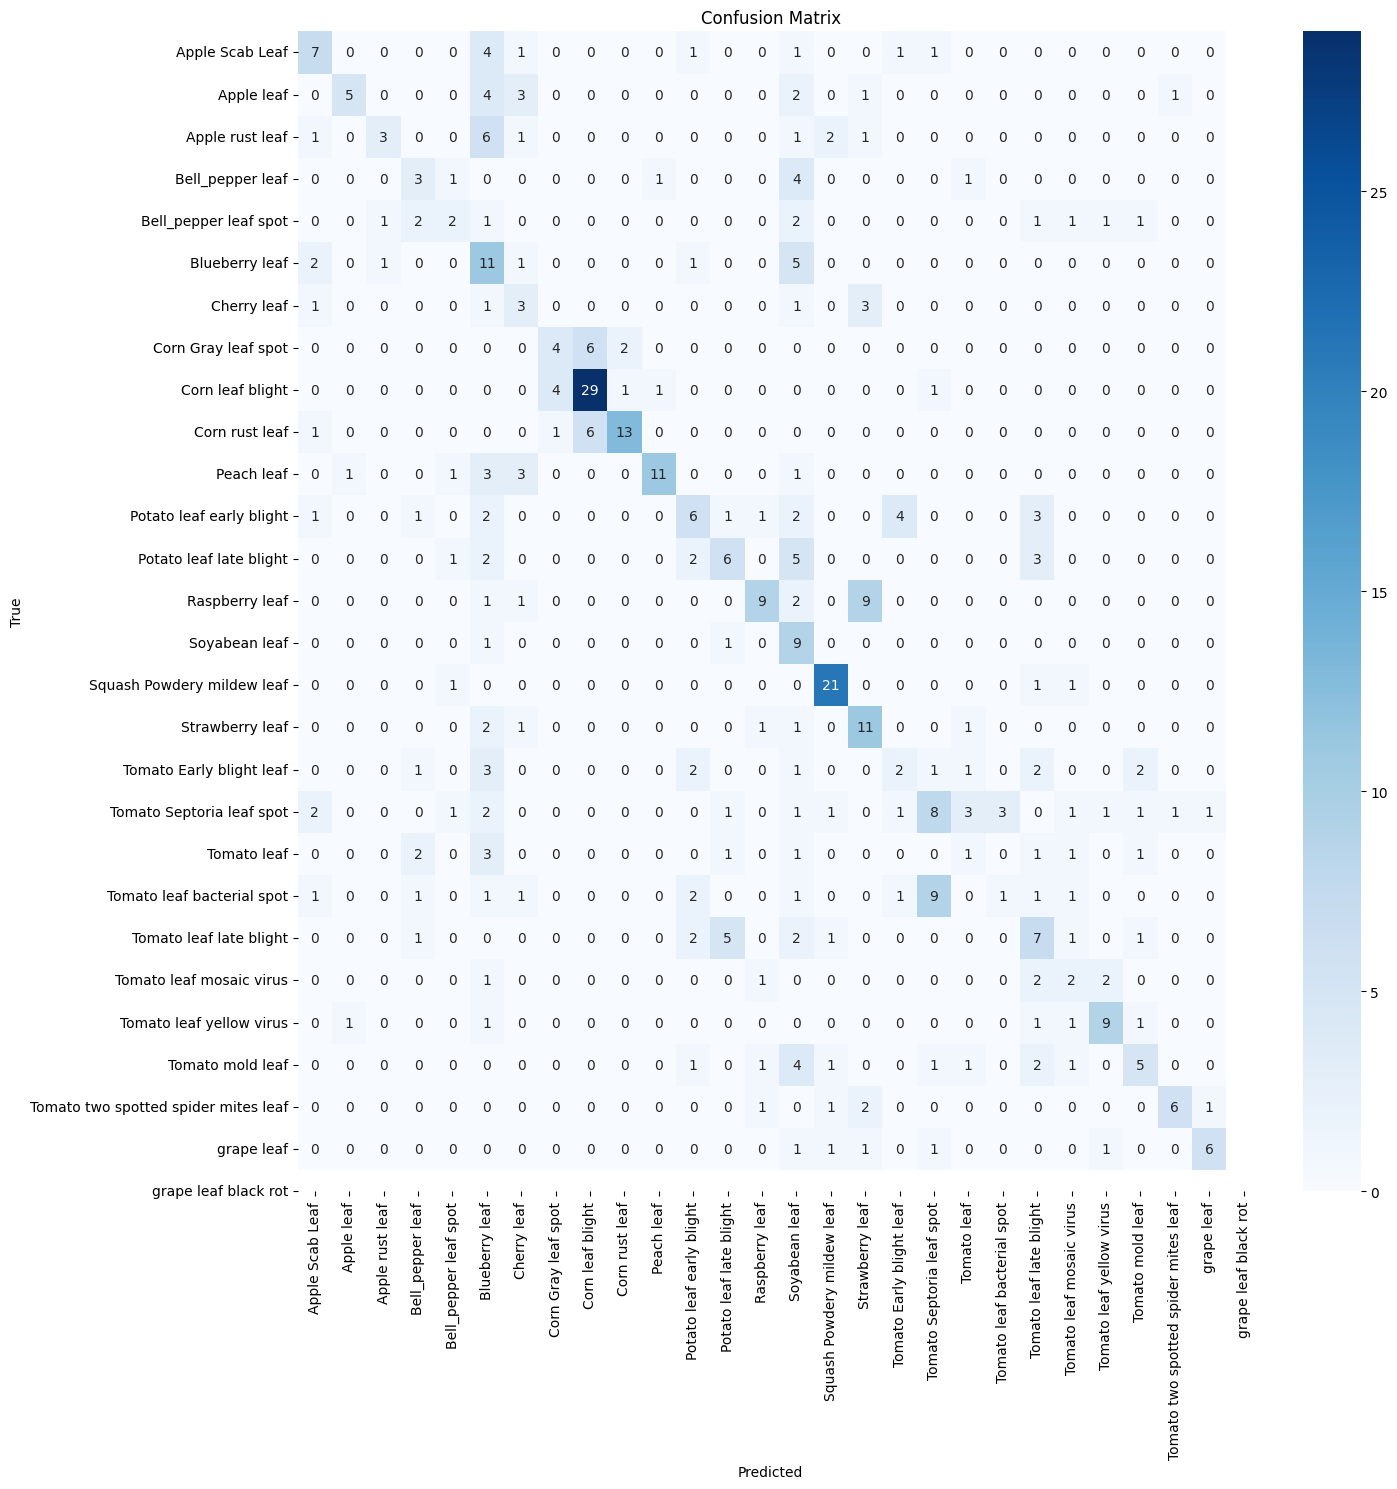

Model saved to plant_disease_model.h5


In [ ]:
# Step 12: Evaluate the model
print("Evaluating model...")

# Reset the generator
validation_generator.reset()

# Calculate loss and accuracy
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions
validation_generator.reset()
y_true = validation_generator.classes
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(
    y_true,
    y_pred,
    labels=range(len(class_names)),
    target_names=class_names
)
print("Classification Report:")
print(report)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Step 13: Save the final model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

In [ ]:
# Step 14: Download the model and visualizations
from google.colab import files
files.download(MODEL_SAVE_PATH)
files.download("confusion_matrix.png")
files.download("training_history.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

p2

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load your trained model
model = load_model('plant_disease_model.h5')

# Define class names (replace with your actual class names from training)
class_names = [
    'Apple leaf', 'Apple rust leaf', 'Apple Scab Leaf', 'Bell_pepper leaf',
    'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot',
    'Corn leaf blight', 'Corn rust leaf', 'grape leaf', 'grape leaf black rot',
    'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf',
    'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf',
    'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus',
    'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato Septoria leaf spot',
    'Tomato two spotted spider mites leaf'
]

def predict_disease(img_path, show_image=True):
    """
    Predict plant disease from an image

    Args:
        img_path: Path to the plant image
        show_image: Whether to display the image with prediction

    Returns:
        predicted_class: The predicted disease class
        confidence: Confidence score (0-100%)
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = float(predictions[0][predicted_class_index] * 100)

    # Display results
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

    # Show top 3 predictions
    top3_indices = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for i, idx in enumerate(top3_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[0][idx]*100:.2f}%")

    # Display the image with prediction
    if show_image:
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"Diagnosis: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        plt.show()

    return predicted_class, confidence

# Example usage:
# predict_disease('path_to_your_plant_image.jpg')